In [1]:
import copick
import pandas as pd
import zarr
from matplotlib import pyplot as plt
import os
import json
import numpy as np
from keras import layers, models
from keras.api.losses import BinaryCrossentropy
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from numba import njit, prange
import time
from sklearn.model_selection import train_test_split


def get_copick_root(split):
    config_path = '../../copick_config.json' if split == 'train' else '../../copick_config_test.json'
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Configuration file not found: {config_path}")
    copick_root = copick.from_file(config_path)
    return copick_root


def get_static_tomogram(run_name, split='train', tomo_type='denoised', zarr_group_idx=0):
    copick_root = get_copick_root(split)
    run = copick_root.get_run(run_name)
    voxel_spacing = run.get_voxel_spacing(10.000)
    tomogram = voxel_spacing.get_tomogram(tomo_type)
    zarr_store = tomogram.zarr()
    zarr_group = zarr.open(zarr_store, mode='r')
    try:
        tomogram_vals = zarr_group[str(zarr_group_idx)][:]  # Use string keys if necessary
    except KeyError:
        raise KeyError(f"Zarr group index {zarr_group_idx} not found in the store.")
    return tomogram_vals


def get_label_locations(run_name, copick_root, voxel_spacing=10):
    picks_folder = os.path.join(copick_root.config.overlay_root, 'ExperimentRuns', run_name, 'Picks')
    if not os.path.exists(picks_folder):
        raise FileNotFoundError(f"Picks folder not found: {picks_folder}")

    picks = {}
    for json_file in os.listdir(picks_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(picks_folder, json_file)
            with open(json_path, 'r') as file:
                pick_data = json.load(file)
            particle_name = json_file[:-5]  # Remove '.json' extension
            picks[particle_name] = np.array([
                [
                    point['location']['x'] / voxel_spacing,
                    point['location']['y'] / voxel_spacing,
                    point['location']['z'] / voxel_spacing
                ]
                for point in pick_data.get('points', [])
            ])
    return picks


import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from numba import njit, prange


@njit(parallel=True)
def add_gaussian_to_heatmap_max(heatmap, z, y, x, kernel, half_size, depth, height, width):
    """
    Adds a Gaussian kernel to the heatmap at the specified (z, y, x) location using maximum.
    """
    for i in prange(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            for k in range(kernel.shape[2]):
                zi = z + i - half_size
                yi = y + j - half_size
                xi = x + k - half_size
                if 0 <= zi < depth and 0 <= yi < height and 0 <= xi < width:
                    if kernel[i, j, k] > heatmap[zi, yi, xi]:
                        heatmap[zi, yi, xi] = kernel[i, j, k]


def generate_heatmaps_optimized_max(df, tomogram_shape, particle_types):
    """
    Optimized function to generate 3D heatmaps for particle locations with maximum Gaussian spread.
    """
    depth, height, width = tomogram_shape
    num_classes = len(particle_types)
    heatmaps = np.zeros((depth, height, width, num_classes), dtype=np.float32)

    # Map particle types to channels
    particle_to_channel = {particle: i for i, particle in enumerate(particle_types)}

    # Group by 'particle' and 'radius'
    grouped = df.groupby(['particle', 'radius'])

    # Precompute Gaussian kernels for each group with adjusted sigma
    kernels = {}
    for (particle, radius), group in grouped:
        # Adjust sigma to ensure rapid decay within radius
        sigma = radius  # Consider setting to radius / 3 for faster decay
        if sigma == 0:
            # Handle cases where radius is zero to avoid division by zero
            kernel = np.zeros((1, 1, 1), dtype=np.float32)
            kernel[0, 0, 0] = 1.0
            kernels[(particle, radius)] = (kernel, 0)
            continue

        # Define the size of the kernel; typically 6*sigma to capture the Gaussian effectively
        kernel_size = int(6 * sigma) + 1  # Ensure kernel size is odd
        half_size = kernel_size // 2
        x = np.arange(-half_size, half_size + 1)
        y = np.arange(-half_size, half_size + 1)
        z_axis = np.arange(-half_size, half_size + 1)
        zz, yy_grid, xx = np.meshgrid(z_axis, y, x, indexing='ij')
        kernel = np.exp(-(xx ** 2 + yy_grid ** 2 + zz ** 2) / (2 * sigma ** 2))
        kernel /= kernel.max()  # Normalize the kernel peak to 1
        kernels[(particle, radius)] = (kernel.astype(np.float32), half_size)

    # Iterate over groups and add Gaussian kernels to the heatmaps
    for (particle, radius), (kernel, half_size) in tqdm(kernels.items(), desc="Generating Heatmaps"):
        channel = particle_to_channel[particle]
        # Extract all particles in the current group
        mask = (df['particle'] == particle) & (df['radius'] == radius)
        particles = df[mask][['z', 'y', 'x']].to_numpy().astype(np.int32)  # Order: z, y, x

        # Add Gaussian kernels to the heatmap using maximum
        for z, y, x in particles:
            add_gaussian_to_heatmap_max(
                heatmaps[..., channel],
                z, y, x,
                kernel, half_size,
                depth, height, width
            )

    return heatmaps

def generate_all_heatmaps_optimized(tomograms, particle_locations_df, particle_types, tomogram_shape):
    """
    Generates heatmaps for all tomograms using the optimized heatmap generation function.
    
    Args:
        tomograms (list): List of tomogram dictionaries with 'run' and 'tomogram' keys.
        particle_locations_df (pd.DataFrame): DataFrame with particle locations.
        particle_types (list): List of unique particle types.
        tomogram_shape (tuple): Shape of the tomogram (depth, height, width).
    
    Returns:
        X (np.ndarray): Normalized tomogram data.
        Y (np.ndarray): Corresponding heatmaps.
    """
    X = []
    Y = []
    
    for tomo in tqdm(tomograms, desc="Processing Tomograms"):
        run_name = tomo['run']
        tomogram_data = tomo['tomogram']
        
        # Normalize tomogram
        tomogram_normalized = (tomogram_data - tomogram_data.min()) / (tomogram_data.max() - tomogram_data.min())
        tomogram_normalized = tomogram_normalized[..., np.newaxis]  # Add channel dimension
        X.append(tomogram_normalized)
        
        # Filter labels for the current run
        labels = particle_locations_df[particle_locations_df['run'] == run_name]
        
        # Generate heatmaps for this tomogram
        if not labels.empty:
            heatmaps = generate_heatmaps_optimized_max(labels, tomogram_shape, particle_types)
        else:
            # If no labels, initialize empty heatmaps
            heatmaps = np.zeros((tomogram_shape[0], tomogram_shape[1], tomogram_shape[2], len(particle_types)), dtype=np.float32)
        
        Y.append(heatmaps)
    
    X = np.array(X)
    Y = np.array(Y)
    return X, Y


def build_3d_cnn(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(layers.Conv3D(num_classes, kernel_size=(3, 3, 3), activation='sigmoid', padding='same'))

    return model


def overlay_heatmaps_on_tomogram(tomogram_slice, heatmaps_slice, particle_types, threshold=0.3):
    tomogram_normalized = (tomogram_slice - tomogram_slice.min()) / (tomogram_slice.max() - tomogram_slice.min())
    tomogram_rgb = np.stack([tomogram_normalized] * 3, axis=-1)

    cmap = plt.cm.get_cmap('tab10', len(particle_types))
    particle_colors = [cmap(i)[:3] for i in range(len(particle_types))]

    overlay = np.zeros_like(tomogram_rgb, dtype=np.float32)

    for i, particle_color in enumerate(particle_colors):
        heatmap = heatmaps_slice[..., i]
        mask = heatmap > threshold
        for c in range(3):
            overlay[..., c] += particle_color[c] * mask.astype(np.float32)

    combined = tomogram_rgb + overlay
    combined = np.clip(combined, 0, 1)

    plt.figure(figsize=(10, 8))
    plt.imshow(combined, interpolation='nearest')
    plt.axis('off')
    plt.title('Tomogram Slice with Heatmap Overlay')
    plt.show()


In [2]:
# Load copick configurations
copick_root_train = get_copick_root('train')
copick_root_test = get_copick_root('test')

In [3]:
# Retrieve run names
training_runs = copick_root_train.runs
testing_runs = copick_root_test.runs

training_run_names = [run.name for run in training_runs]
testing_run_names = [run.name for run in testing_runs]
extra_training_run_names = list(set(training_run_names) - set(testing_run_names))

print(f'Training runs: {training_run_names}')
print(f'Testing runs: {testing_run_names}')
print(f'Extra training runs not in testing: {extra_training_run_names}')

Training runs: ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
Testing runs: ['TS_5_4', 'TS_69_2', 'TS_6_4']
Extra training runs not in testing: ['TS_73_6', 'TS_6_6', 'TS_99_9', 'TS_86_3']


In [4]:
# Load tomograms
tomograms_train = []
tomograms_test = []

for training_run_name in training_run_names:
    try:
        tomo = get_static_tomogram(split='train', run_name=training_run_name)
        tomograms_train.append({'run': training_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {training_run_name}: {e}")

for testing_run_name in testing_run_names:
    try:
        tomo = get_static_tomogram(split='test', run_name=testing_run_name)
        tomograms_test.append({'run': testing_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {testing_run_name}: {e}")

print(f'Number of train tomograms: {len(tomograms_train)}')
print(f'Number of test tomograms: {len(tomograms_test)}')

Number of train tomograms: 7
Number of test tomograms: 3


In [5]:
# Verify the loaded tomograms
if tomograms_train:
    sample_tomo = tomograms_train[0]['tomogram']
    print(f"Type: {type(sample_tomo)}")
    print(f"Element Type: {type(sample_tomo[0])}")
    print(f"Shape: {sample_tomo.shape}")
else:
    print("No training tomograms loaded.")

Type: <class 'numpy.ndarray'>
Element Type: <class 'numpy.ndarray'>
Shape: (184, 630, 630)


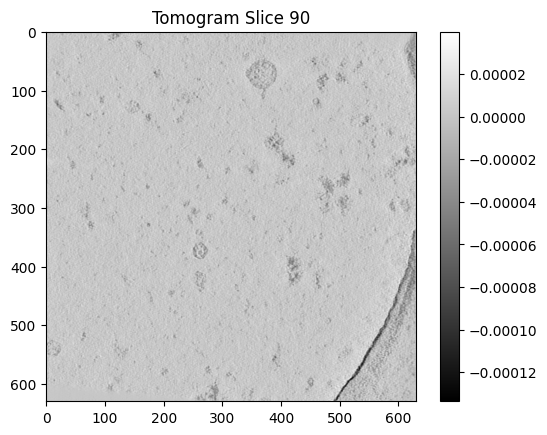

In [6]:
# Visualize a slice
if tomograms_train:
    slice_index = 90  # Adjust as needed
    if slice_index < tomograms_train[0]['tomogram'].shape[0]:
        plt.imshow(tomograms_train[0]['tomogram'][slice_index], cmap='gray')
        plt.title(f"Tomogram Slice {slice_index}")
        plt.colorbar()
        plt.show()
    else:
        print(
            f"Slice index {slice_index} out of range for tomogram with depth {tomograms_train[0]['tomogram'].shape[0]}")
else:
    print("No training tomograms to visualize.")

In [7]:
# Create DataFrame with particle locations
rows = []
for run in training_run_names:
    try:
        label_data = get_label_locations(run, copick_root_train)
        for particle, locations in label_data.items():
            matching_particles = [obj.radius for obj in copick_root_train.config.pickable_objects if
                                  obj.name == particle]
            if not matching_particles:
                print(f"No matching particle found for {particle} in run {run}")
                continue
            radius = matching_particles[0] / 10
            for location in locations:
                rows.append({
                    'run': run,
                    'particle': particle,
                    'x': location[0],
                    'y': location[1],
                    'z': location[2],
                    'radius': radius
                })
    except Exception as e:
        print(f"Error processing labels for run {run}: {e}")

particle_locations_df = pd.DataFrame(rows)
print(particle_locations_df.sample(5))
print(f"Total labeled particles: {len(particle_locations_df)}")

         run       particle         x         y         z  radius
216  TS_69_2   apo-ferritin   66.8986  104.1449  110.2246     6.0
714  TS_73_6   apo-ferritin   23.8946  485.3061   90.9898     6.0
660  TS_73_6       ribosome  221.3117  291.8397  125.2563    15.0
769  TS_73_6   apo-ferritin  315.5737  250.9436   14.9875     6.0
265  TS_69_2  thyroglobulin  504.9901  412.3515  109.2673    13.0
Total labeled particles: 1269


In [8]:
# Define particle types and tomogram shape
particle_types = sorted(particle_locations_df['particle'].unique())
if tomograms_train:
    tomogram_shape = tomograms_train[0]['tomogram'].shape
    print(f"Tomogram shape: {tomogram_shape}")
else:
    raise ValueError("No training tomograms available to determine shape.")

# Prepare input and label data
X, Y = generate_all_heatmaps_optimized(tomograms_train, particle_locations_df, particle_types, tomogram_shape)
print(f"Input shape (X): {X.shape}")
print(f"Label shape (Y): {Y.shape}")

Tomogram shape: (184, 630, 630)


Processing Tomograms: 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Input shape (X): (7, 184, 630, 630, 1)
Label shape (Y): (7, 184, 630, 630, 6)


/var/folders/dq/6g5fch396qb663c0xjt8xsxr0000gp/T/ipykernel_68985/2476151924.py:201: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(particle_types))


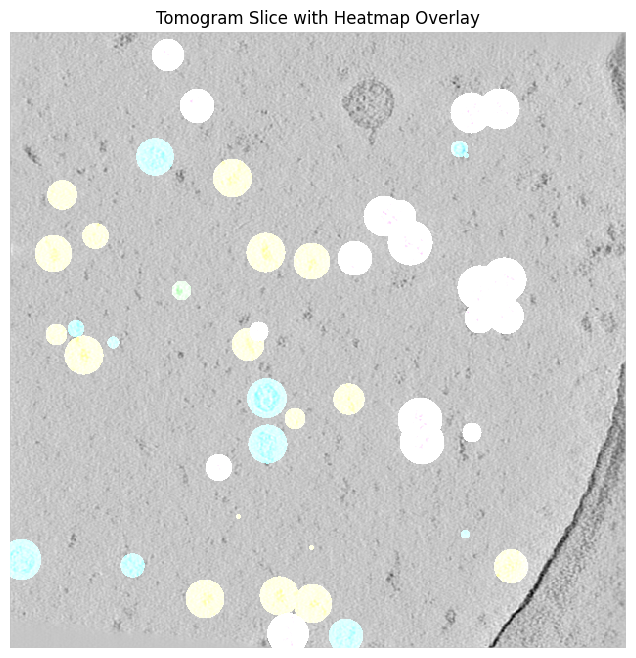

In [9]:
# Visualize a specific slice with heatmaps
slice_index = 90  # Adjust as needed
threshold = 0.3

if slice_index < X.shape[1]:
    tomogram_slice = X[0, slice_index, :, :, 0]
    heatmaps_slice = Y[0, slice_index, :, :, :]
    overlay_heatmaps_on_tomogram(tomogram_slice, heatmaps_slice, particle_types, threshold)
else:
    print(f"Slice index {slice_index} out of range for tomogram with depth {X.shape[1]}")

In [10]:
# Build the 3D CNN model
input_shape = X.shape[1:]  # (depth, height, width, channels)
num_classes = Y.shape[-1]
model = build_3d_cnn(input_shape=input_shape, num_classes=num_classes)
model.summary()

/Users/jake.brannigan/Documents/Kaggle/CryoET/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 184, 630, 630,  │           448 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 92, 315, 315,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 92, 315, 315,   │        13,856 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 46, 157, 157,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 46, 157, 157,   │         5,190 │
│                                 │ 6)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,494 (76.15 KB)

 Trainable params: 19,494 (76.15 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile the model
loss = BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [12]:
# Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (5, 184, 630, 630, 1)
Validation data shape: (2, 184, 630, 630, 1)


In [13]:
# Define training parameters
batch_size = 2  # Adjust based on your hardware capabilities
epochs = 2

In [14]:
subset_size = 10

In [ ]:
from keras.api.callbacks import TensorBoard
import datetime

# Define TensorBoard log directory
log_dir = f"./logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(
    X_train[:subset_size], Y_train[:subset_size],
    validation_data=(X_val[:subset_size], Y_val[:subset_size]),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    callbacks=[tensorboard_callback]
)
